# Predict viral tweets

In [45]:
SEED = 26062019

test_size = 0.5 

import sys
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers
import numpy as np
#import pickle
from yellowbrick import __version__ as yb_vers
#import NLP_functions as func
#from pattern import __version__ as pat_vers
#import random
#from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
#import sklearn.ensemble as ske
#import re
#import xgboost as xgb
#import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


#### install NLTK

In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\levrex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Load data

In [14]:
df_tweets = pd.read_csv(r'input/0_initial/trumptweets.csv', sep=',')
df_tweets['date'] = pd.to_datetime(df_tweets['date']) # interpret date as pd.datetime
print('nr of tweets: ', len(df_tweets))
df_tweets.head()

nr of tweets:  41122


,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN


In [15]:
print('First tweet: ', df_tweets['date'].min())
print('Final tweet: ', df_tweets['date'].max())

First tweet:  2009-05-04 20:54:25
Final tweet:  2020-01-20 02:57:49


### Date cut-off
Only select tweets after the moment he announced that he was a presidential candidate

In [16]:
df_tweets.loc[32059]['content']

'# FraudNewsCNN # FNNpic.twitter.com/WYUnHjjUjg'

In [17]:
df_tweets = df_tweets[df_tweets['date']>pd.Timestamp('2015-06-16T12')] 
print(len(df_tweets))

17823


### Simple Cleaning

In [18]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def lemmatizingText(sentence):
    """
    This function normalizes words with the pattern.nl package. 
    Lemmatisation returns words to the base form. The base form
    should be a valid word in the language.
    Example: Walking, Walks and Walked are all translated to 
        Walk
        
    Input: 
        sentence = written text from an EHR record or another
            Natural Language type record (str)
    """
    lemmatizer = WordNetLemmatizer() 
    return ' '.join([lemmatizer.lemmatize(x) for x in sentence.split(' ')])

def simpleCleaning(sentence):
    # at this moment we ignore whether or not a term is tagged
    sticky_chars = r'([!,.:";@\-#\+\\/&=\]\[<>^\*`â€™\(\)’\d])'
    sentence = re.sub(sticky_chars, r' ', sentence)
    sentence = sentence.lower()
    return sentence

def removeStopWords(sentence):
    return ' '.join([i for i in tweet_tokenizer.tokenize(sentence) if i not in stopwords.words('english')])

tweet_tokenizer = TweetTokenizer()

# convert to lowercase
df_tweets['content'] = df_tweets['content'].str.lower()
# remove links (pic is used for pictures)
df_tweets['content'] = df_tweets['content'].str.replace('http\S+|www.\S+|pic.\S+', '', case=False) #tweet_tokens
# simple cleaning
df_tweets['content'] = df_tweets['content'].apply(lambda x : simpleCleaning(x))       
# lemmatizing
df_tweets['content'] = df_tweets['content'].apply(lambda x : lemmatizingText(x))     
# remove stop words
df_tweets['content'] = df_tweets['content'].apply(lambda x : removeStopWords(x))
# remove spaces
df_tweets['content'] = df_tweets['content'].str.replace(' +', ' ', case=False)

## Most popular tweet

In [5]:
df_tweets[df_tweets['favorites']==df_tweets['favorites'].max()]

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
38625,1157345692517634049,https://twitter.com/realDonaldTrump/status/115...,$ ap rocky released prison way home united sta...,2019-08-02 19:41:30,240363,857678,NaN,NaN,NaN


In [6]:
df_tweets[df_tweets['retweets']==df_tweets['retweets'].max()]

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
32059,881503147168071680,https://twitter.com/realDonaldTrump/status/881...,fraudnewscnn fnn,2017-07-02 15:21:42,309892,528265,NaN,# #,NaN


In [19]:
df_tweets.to_csv(r'input/1_preprocessed/trumptweets_proc.csv', index = False, header=True)


## 2. Create Train, Validation & Test set

In [5]:
import pandas as pd

df_tweets = pd.read_csv(r'input/1_preprocessed/trumptweets_proc.csv', sep=',')
df_tweets['date'] = pd.to_datetime(df_tweets['date']) # interpret date as pd.datetime
print('nr of tweets: ', len(df_tweets))
df_tweets['content'] = df_tweets['content'].fillna('empty')
df_tweets.head()

nr of tweets:  17823


,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,610784050060632065,https://twitter.com/realDonaldTrump/status/610...,big time u today make america great politician...,2015-06-16 14:20:40,283,439,NaN,NaN,NaN
1,610785062599139328,https://twitter.com/realDonaldTrump/status/610...,thanks …,2015-06-16 14:24:41,47,143,NaN,NaN,NaN
2,610794115316498432,https://twitter.com/realDonaldTrump/status/610...,appsame going listen realdonaldtrump really ru...,2015-06-16 15:00:39,47,96,@ @,NaN,NaN
3,610794978055467010,https://twitter.com/realDonaldTrump/status/610...,almost time making major announcement trumptow...,2015-06-16 15:04:05,424,817,@,#,NaN
4,610795920448425984,https://twitter.com/realDonaldTrump/status/610...,make sure follow periscopeco makeamericagreata...,2015-06-16 15:07:50,67,171,@,#,NaN


In [126]:
from sklearn.model_selection import train_test_split
SEED = 232020

X = df_tweets['content']
y = df_tweets['retweets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

df_train = pd.DataFrame(data={'X': X_train, 'y': y_train})
df_test = pd.DataFrame(data={'X': X_test, 'y': y_test})

print('Size train:\t', len(df_train))
print('Size test:\t', len(df_test))

Size train:	 13367
Size test:	 4456


## 3. Visualize Exploration data
### 3.1 Lexical plot of trainingsset

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import DispersionPlot

def plotLexicalDispersion(X, nr_features, title, **kwargs):
    """
    Draws a lexical dispersion plot which visualizes 
    the homogeneity across the corpus. 
    
    Also confirms wheter or not the data is randomized, 
    and visualizes the prevalence of features.
    
    Input:
        X = array with text data (EHR entries)
        nr_features = top n number of features to plot
        n_grams = chunksize for text processing :
            Note: chunksize refers to nr of words / not nr of 
                characters!
        kwargs = arguments for feature vectorizer (TfidfVectorizer):
            ngram_range = specifies the range of the ngram features
    """
    count = 0
    d = {}
    words = []
    for x in X:
        if kwargs['ngram_range'][1] != 1:
            # functie crasht bij hashtags
            l = [i for i in x.split(' ')]
            words.append([' '.join(l[i: i+(kwargs['ngram_range'][1])]) for i in range(len(l)+1) if len(l[i: i+(kwargs['ngram_range'][0])]) <= (kwargs['ngram_range'][1])])
            
            #print(words)
            if len(words[-1]) == 0:
                del words[-1]
        else :
            words.append([i for i in x.split(' ')])
        count+=1
    d = np.array(words)
    count_vect = TfidfVectorizer(ngram_range=kwargs['ngram_range'])
    
    
    X_train_tfidf = count_vect.fit_transform(X) 
    X_pd = pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())
    feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:nr_features]) 
    visualizer = DispersionPlot(feature_to_plot, size=(450, 450))
    ax = visualizer.ax
    ax.tick_params(labelsize=18)
    visualizer.fit(d)
    visualizer.poof()
    return

C:\Users\levrex\Anaconda3\lib\site-packages\yellowbrick\text\dispersion.py:173: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_target = np.stack(self._compute_dispersion(X, y))
C:\Users\levrex\Anaconda3\lib\site-packages\yellowbrick\text\dispersion.py:177: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  zip(points_target[:, 0].astype(int), points_target[:, 1].astype(int))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points

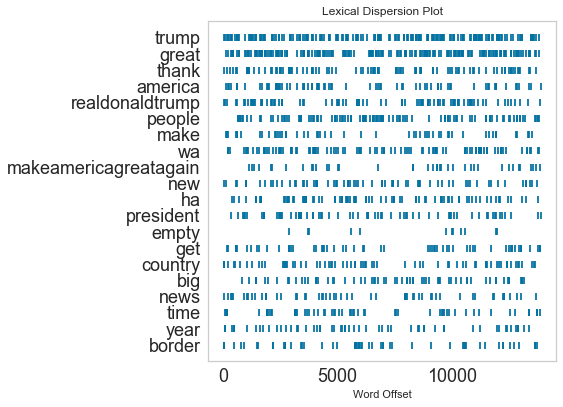

<Figure size 576x396 with 0 Axes>

In [82]:
title ='Lexical Dispersion Plot of most popular chunks (n=2) in last 1000 Trump tweets'
plotLexicalDispersion(df_train['X'].tail(1000), nr_features=20, title=title, ngram_range=(1,1))
plt.savefig('figures/prep/LexicalDispersionPlot.png', bbox_inches='tight')

<module 'matplotlib.pyplot' from 'C:\\Users\\levrex\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

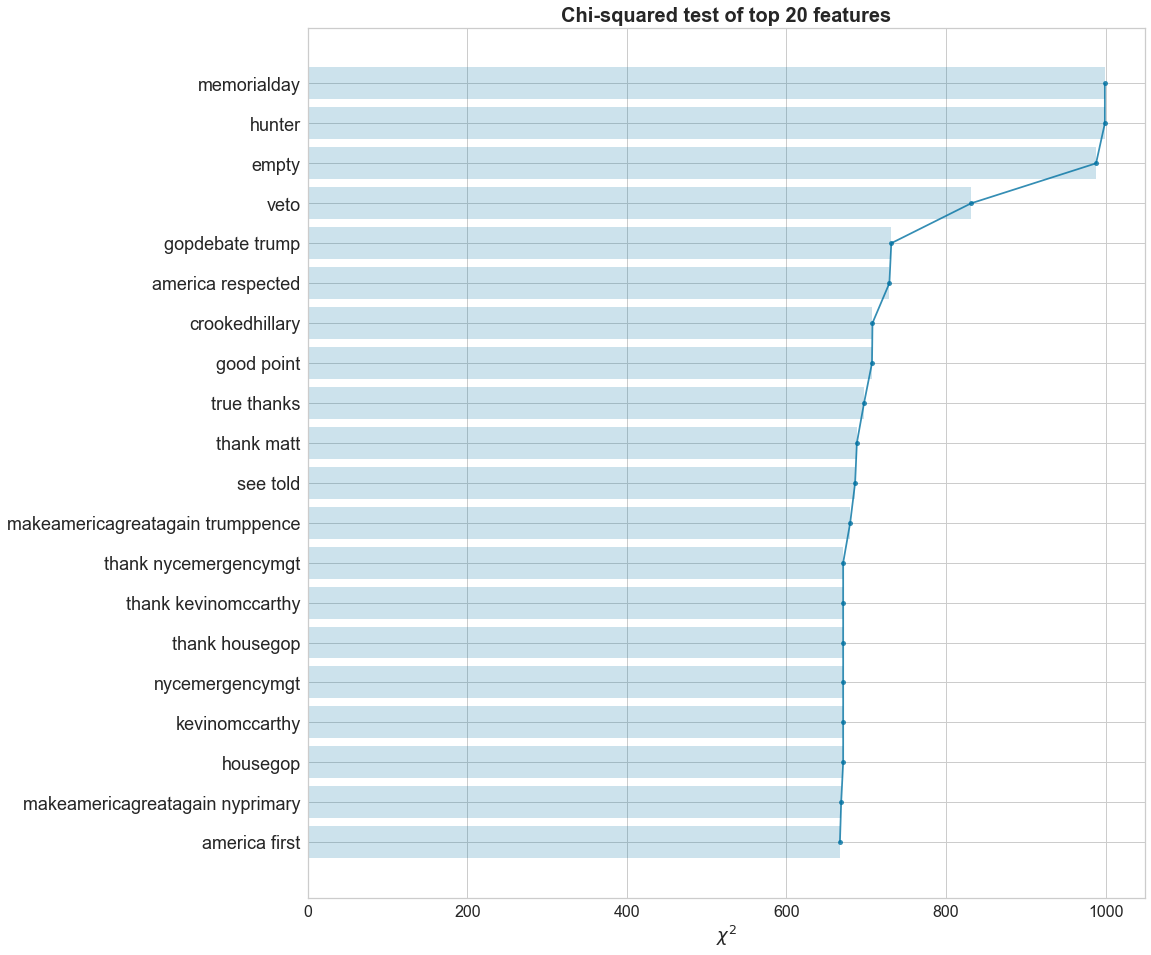

In [83]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

def plotFeatureChiSquared(X_train_fold, y_train_fold, nr_features, **kwargs):
    """
    Draw a chi squared plot for the top n features
    
    Input:
        X_train_fold = array with text data (EHR entries) from
            trainingsset
        y_train_fold = labels of the trainingsset
        nr_features = specifies the nr of features to draw 
            (descending order)
        n_grams = chunk text on n_grams / motifs rather than
            on whitespace
        kwargs = arguments for feature vectorizer (TfidfVectorizer):
            ngram_range = specifies the range of the ngram features
    Output:
        plt = matplotlib pyplot showcasing the correlation for
            each of the most occurring features
    """
    tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
    x_train_tfidf = tvec.fit_transform(X_train_fold)
    chi2score = chi2(x_train_tfidf, y_train_fold)[0]
    
    plt.figure(figsize=(15 ,10+ 6*(nr_features/20)))
    wscores = zip(tvec.get_feature_names(), chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-nr_features:]))
    #topchi2 = list(zip(*wchi2[:nr_features]))
    
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x ,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x , '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=18)
    plt.xticks(fontsize=16)
    plt.xlabel('$\chi^2$', fontsize=18)
    plt.title('Chi-squared test of top ' + str(nr_features) + 
                  ' features', fontsize=20, fontweight='bold')
    return plt

# Instantiate the visualizer


#visualizer.fit(X, y)        # Fit the data to the visualizer
#visualizer.show()       
title ='Lexical Dispersion Plot of most popular chunks (n=2) in last 1000 Trump tweets'
plotFeatureChiSquared(df_train['X'].tail(1000), df_train['y'].tail(1000), nr_features=20, title=title, ngram_range=(1,1))

## 3. Annotate tweets to be either Viral or not Viral (binary labelling)

In [118]:
print('Tweets that qualify as being popular (10% of total in exploration set): ', round(len(df_train['y'])*0.25))

Tweets that qualify as being popular (10% of total in exploration set):  3342


In [127]:
df_train = df_train.sort_values(by='y').reset_index()
class_y_train = df_train['y']
minimal_ix = len(y_train) - round(len(y_train)*0.25)
cutoff = class_y_train.loc[minimal_ix]
print('Tweets with more than %s retweets are considered to be viral in Trump terms!' % (cutoff))

# Relabel y_Train & y_test to binary label (Viral or not Viral)
df_train['label'] = df_train['y'].sort_values().apply(lambda x: 'True' if x > cutoff else 'False')
df_test['label'] = df_test['y'].sort_values().apply(lambda x: 'True' if x > cutoff else 'False')

Tweets with more than 18145 retweets are considered to be viral in Trump terms!


### 3.1 Distribution Favorites with cut-off

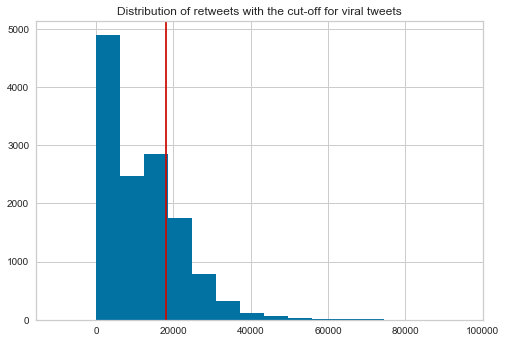

In [120]:
plt.hist(df_train['y'].sort_values(), bins=50)
plt.axvline(x=cutoff, color='r')
plt.xlim(right=100000) 
plt.title('Distribution of retweets with the cut-off for viral tweets')
plt.savefig('figures/prep/DistributionFavoriteTweets.png', bbox_inches='tight')

### 3.2 Distribution classes (Viral / Non Viral)

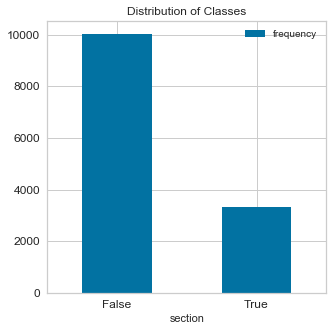

In [121]:
from collections import Counter

labels, values = zip(*Counter(df_train['label']).items())
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of Classes", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

## 4. Investigating Vector space (Word2Vec)

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\levrex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 4.1 creating Vectorspace with Word2Vec

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import gensim 
from gensim.models import Word2Vec
tweet_tokens = []

# later on respect the l_folds

for sent in X_train:
    tweet_tokens.append(tweet_tokenizer.tokenize(sent))

print('Training word2vec model...')
word2vec = Word2Vec(tweet_tokens, size=100, window=5, min_count=5, workers=4)  
word2vec.init_sims(replace=True)


### 4.2 Investigating the vector space

In [234]:
print("Cosine similarity:\n'america' and 'great':\t", word2vec.wv.similarity('america', 'great')) 
print("'american' and 'great':\t", word2vec.wv.similarity('american', 'great')) 
print("'cnn' and 'fake':\t", word2vec.wv.similarity('cnn', 'fake'))
print("'democrat' and 'great':\t", word2vec.wv.similarity('democrat', 'great')) 
print("'Hillary' and 'great':\t", word2vec.wv.similarity('hillary', 'great')) 
print("'Hillary' and 'crooked':", word2vec.wv.similarity('hillary', 'crooked')) 

Cosine similarity:
'america' and 'great':	 0.96070176
'american' and 'great':	 0.7700361
'cnn' and 'fake':	 0.8299973
'democrat' and 'great':	 0.16770846
'Hillary' and 'great':	 -0.0682913
'Hillary' and 'crooked': 0.9585856


In [239]:
print("News + Trump - FoxNews = ", word2vec.wv.most_similar(positive=['news', 'trump'], negative=['foxnews'], topn=1))
print("News + Trump - CNN = ", word2vec.wv.most_similar(positive=['news', 'trump'], negative=['cnn'], topn=1))
print("Which one doesn't match: Trump, Democrat, Republican and Foxnews:", word2vec.wv.doesnt_match("trump democrat republican foxnews".split()))

News + Trump - FoxNews =  [('cnn', 0.8376795053482056)]
News + Trump - CNN =  [('foxnews', 0.851902961730957)]
Which one doesn't match: Trump, Democrat, Republican and Foxnews: democrat


In [247]:
print("Most associations with Hillary")
word2vec.wv.similar_by_word("hillary", 5)

Most associations with Hillary


[('clinton', 0.9729011058807373),
 ('crooked', 0.9585856199264526),
 ('flunky', 0.8961525559425354),
 ('campaign', 0.8677566647529602),
 ('foundation', 0.8625138998031616)]

## 5. Build Classifier 
1. Use TFIDF vectorizer (Word2Vec cannot be used for a classifier?)
2. Use ROC curve with 5 cross folds 

In [148]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

def plotSTD(tprs, aucs, color, lbl, linestyle='-', lw=5):
        """
        Plot the standard deviation of the ROC-curves

        Input:
            tprs = list of true positive rates per iteration
            aucs = list of area under the curve per iteration
            lbl = name of the classifier (string)
            color = specify color of the classifier
            lw = linewidth (float)
        Output:
            plt = matplotlib pyplot featuring the standard 
                deviation of the ROC curve from the classifier
            std_auc = standard deviation of the auc (float)
        """
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr [-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        print(lbl + ' ' + str(mean_auc) +' (std : +/-' + "%.2f" % std_auc + ' )')
        plt.plot(mean_fpr, mean_tpr, color=color,
            label=lbl + r' mean kfold (AUC = %.2f +/- %.2f)' % (mean_auc, std_auc),
            alpha=.5, linestyle=linestyle, linewidth=lw)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.1)
        return plt 
    
    
def plotSwarm(Y, X, lbl):
    df = pd.DataFrame(data={'Y': Y, 'X': X})
    fig = sns.swarmplot(x="X", y="Y", data=df)
    plt.ylabel('Probability')
    plt.xlabel('Label')
    plt.title('Swarm plot ' + str(lbl))
    return fig

In [155]:
def plot_confusion_matrix(y_pred, y_true, lbl, classes=[0,1],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    [SKLEARN function]
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    

## New function for CV

In [158]:
from sklearn.model_selection import cross_validate,KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_validate,KFold
from sklearn.metrics import f1_score
import datetime
import time
import pandas as pd
import random

sgd = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, class_weight={1: 4, 0:1},  n_iter_no_change=5, random_state=42)
#a list of classifiers
classifiers = [MultinomialNB(),PassiveAggressiveClassifier(), BernoulliNB(),LogisticRegression(),LinearSVC(),AdaBoostClassifier(),RidgeClassifier(),Perceptron()]
clf_names = ['MultinomialNB()', 'PassiveAggressiveClassifier()', 'BernoulliNB()','LogisticRegression()','LinearSVC()','AdaBoostClassifier()','RidgeClassifier()','Perceptron()']

def assess_performance(X, y, clf, label, gram):
    tprs, aucs = [], []
    fpr_scale = np.linspace(0, 1, 100)
    avg_auc, acc, avg_auc_train, acc_train, avg_f1_score = 0, 0, 0, 0, 0
    
    before = datetime.datetime.now()
    before = before.strftime("%H:%M:%S")
    start = time.time()
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=SEED)
    cv = TfidfVectorizer(ngram_range=(1,gram))
    classifier = make_pipeline(cv,clf)
    for i, (train, test) in enumerate(kfold.split(X, y)):
        classifier.fit(X.iloc[train].values.astype('U'), y.iloc[train].values.astype('U'))
        y_pred = classifier.predict(X.iloc[test].values.astype('U'))
        y_pred = np.array([1 if i == 'True' else 0 for i in y_pred])
        
        y_pred_train = classifier.predict(X.iloc[train].values.astype('U'))
        y_pred_train = np.array([1 if i == 'True' else 0 for i in y_pred_train])
        
        # Performance Test
        fpr, tpr, thresholds = roc_curve(np.array([1 if i == 'True' else 0 for i in y.iloc[test].values.astype('U')]), y_pred)
        tprs.append(np.interp(fpr_scale, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        avg_auc += roc_auc
        acc += accuracy_score(y_pred, np.array([1 if i == 'True' else 0 for i in y.iloc[test].values.astype('U')]))
        avg_f1_score += f1_score([1 if i == 'True' else 0 for i in y.iloc[test].values.astype('U')], y_pred)
        
        # Performance Train
        fpr, tpr, thresholds = roc_curve(np.array([1 if i == 'True' else 0 for i in y.iloc[train].values.astype('U')]), y_pred_train)
        avg_auc_train += auc(fpr, tpr)
        acc_train += accuracy_score(y_pred_train, np.array([1 if i == 'True' else 0 for i in y.iloc[train].values.astype('U')]))
        
    plt = plotSTD(tprs, aucs, 'r', label)
    plt.savefig("performance/ROC/"+label+"_ROC.png")
    plt.close()
    df_swarm = pd.DataFrame(data={'True': [1 if i == 'True' else 0 for i in y.iloc[test].values.astype('U')], 
                                'Pred' : y_pred})
    plt = plot_confusion_matrix(df_swarm['Pred'], df_swarm['True'], label)
    fig = plt.get_figure()    
    fig.savefig("performance/Confusion_matrix/"+label+"_conf.png")
    fig.clf()
    after = datetime.datetime.now()
    after = after.strftime("%H:%M:%S")
    end = time.time()
    hours = int(after[0:2])-int(before[0:2])
    mins = int(after[3:5])-int(before[3:5])
    secs = int(after[6:8])-int(before[6:8])
    time_taken = str(hours)+":"+str(mins)+":"+str(secs)
    return [label,acc_train/10, acc/10, avg_auc_train/10, avg_auc/10, avg_f1_score/10, end-start]

for gram in range(1,4):
    i=0
    data=[]
    for clf in classifiers[0:2]:
        results_perf = assess_performance(df_train['X'], df_train['label'], clf, 'N'+str(gram)+'_'+clf_names[i], gram)
        data.append(results_perf)
        i += 1 
    d = pd.DataFrame(data,columns=['Classifier', 'Accuracy_train','Accuracy_test', 'AUC_train', 'AUC_test', 'F1_score', 'Time taken']) # to add train score / test score
    d['Ac_rank'] = d['Accuracy_test'].rank(ascending=False)
    d['Time_rank'] = d['Time taken'].rank(ascending=False)
    d['C-rank'] = d['Ac_rank'] + d['Time_rank']
    d['C-rank'] = d['C-rank'].rank(ascending=False)
    i+=1
    #print(d)
    gr = str(gram)
    fname = "performance/cv_"+gr+"clfs.csv"
    d.to_csv(fname)

N1_MultinomialNB() 0.5698362144330503 (std : +/-0.01 )
N1_PassiveAggressiveClassifier() 0.6704502217685324 (std : +/-0.01 )
N2_MultinomialNB() 0.5113359958341003 (std : +/-0.01 )
N2_PassiveAggressiveClassifier() 0.7264168983336122 (std : +/-0.01 )
N3_MultinomialNB() 0.5059847884248599 (std : +/-0.00 )
N3_PassiveAggressiveClassifier() 0.7436983097211914 (std : +/-0.01 )


<Figure size 576x396 with 0 Axes>